In [23]:
# Module import
from IPython.display import Image
import sys
import pandas as pd

# To use interact -- IPython widget
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


# append to path the folder that contains the analytic scanner
sys.path.append('../GaiaLab/scan/analytic_scanner')
# local imports
#from gaia_analytic_toymodel import *

from scipy import interpolate

import frame_transformations as ft
from scanner import Scanner
from satellite import Satellite
from source import Source

import constants as const

from quaternion import Quaternion
from agis import Agis
from agis import Calc_source
from agis_functions import *

from analytic_plots import *

# Ipython magics
%load_ext autoreload
%autoreload 2
# %matplotlib notebook 
# %matplotlib widget
# %matplotlib ipympl

# Set some user-specific variables
# MAIN_FOLDER = '../' # relative path to project folder
# FIG_FOLDER = 'figures/' # relative path to figure

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Steps: 
* Source detection
* scan

Create three example stars from real data. The Source object takes as inputs:

> Source('name', $\alpha$, $\delta$, parallax, $\mu_{\alpha}$, $\mu_{\delta}$, $\mu_{r}$)

with units: [string, deg, deg, mas, mas/yr, mas/yr, km/s]

Once the satellite and its correspondent attitude object is created, we need to create a scanner. At the moment, the scaner is only able to perform the search of one single star in the sky.  
_**Scanner:**_
The scanner takes in two parameters. The first does a scan of the sky taking the dot product of the x-axis of the scanner (with respect to the LMN-frame) and the star's position (also in LMN). Since the scanning law has an almost perfect coverage of the sky (would be interesting to do a density plot of where it scans more in the future), it selects the times when the star is in this circle field of view. For this example we set it to 20 deg. The second input parameters sets the z-axis value threshold for the scanner ccd dimentions. That is to say, the height of the scanning line that swaps the sky.  
_**To scan:**_
Firstly, the coarse scan is performed, using the desire satellite and the star that we want to scan.
Secondly, we search for the optimized solutions with the fine scan, which uses the data from the coarse scan.

Good_link for frame transformations: http://www.astronexus.com/a-a/motions-long-term

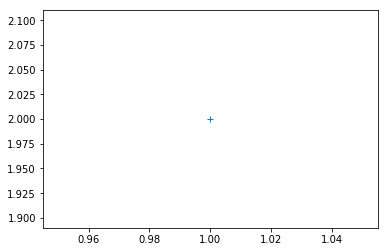

In [2]:
plt.plot(1,2,'+')
plt.show()

In [7]:
# # create all the objects we will need:
# parameters for the notebook
t_init = 0 
t_end = 365*5 # 365*5
my_dt = 1/24 # [days]

# objects
gaia = Satellite(ti=t_init, tf=t_end, dt= my_dt)
print('Sat created')
alpha_sirio = 101.28  # right ascension
delta_sirio = -16.7161  # declination
sirio = Source("sirio", alpha_sirio, delta_sirio, 379.21, -546.05, -1223.14, -7.6 )
sirio2 = Source("sirio2", 98, -15, 350, -500, -1000, -13.9)
print('Source created')
scanSirio = Scanner() 
print('Scanner created')
sirio.reset()
[sirio.alpha, sirio.delta, sirio.parallax, sirio.mu_alpha_dx, sirio.mu_delta]

Sat created
Source created
Scanner created


[1.767669466419857,
 -0.29175098309262415,
 1.8384619601354712e-06,
 -6.9464484158848486e-09,
 -1.6246438518145694e-08]

In [8]:
np.random.seed(seed=1)  # numpy seed set to increase reproducibility
my_observations = np.random.randint(low=t_init, high=t_end, size=10)
my_observations = np.sort(my_observations)
print('my_observations: {}'.format(my_observations))
my_angles = []
for t_j in my_observations:
    my_angle = sirio.topocentric_angles(gaia, t_j)
    my_angles.append(my_angle)
    print('my_angle: {}'.format(my_angle))
# print('my_angles: {}'.format(my_angles))

my_observations: [ 144  235  715  847  905  960 1061 1096 1669 1791]
my_angle: (1.7676672724216531, -0.29175412108367554, -433.42085253781704, -647.257116220907)
my_angle: (1.7676664227762553, -0.2917539356501859, -601.2669483283647, -609.0087134129275)
my_angle: (1.7676658624661659, -0.2917622072561002, -711.955314540682, -2315.1499046716176)
my_angle: (1.7676628935271883, -0.2917658471562842, -1298.4644833115458, -3065.9332108795666)
my_angle: (1.767661233970976, -0.29176593176771737, -1626.3071711950702, -3083.385571753443)
my_angle: (1.7676610709304874, -0.29176578657658697, -1658.5155601872657, -3053.4377513734657)
my_angle: (1.7676630203375494, -0.2917674918132042, -1273.413298345127, -3405.1680518348176)
my_angle: (1.7676632499389362, -0.29176871469633703, -1228.0559098861327, -3657.4058042871366)
my_angle: (1.767655658659607, -0.29177766578719344, -2727.7010568238975, -5503.700825485273)
my_angle: (1.7676577255101844, -0.29177935195658855, -2319.3980154809124, -5851.49822906737

In [9]:
for t in my_observations:
    print(sirio.unit_topocentric_function(gaia,t))

[-0.18733571  0.93924054 -0.28763266]
[-0.18733492  0.93924075 -0.28763248]
[-0.18733393  0.93923852 -0.2876404 ]
[-0.18733094  0.93923805 -0.28764389]
[-0.18732938  0.93923834 -0.28764397]
[-0.18732923  0.93923841 -0.28764383]
[-0.18733097  0.93923756 -0.28764547]
[-0.18733111  0.93923717 -0.28764664]
[-0.18732348  0.93923607 -0.28765521]
[-0.18732533  0.93923521 -0.28765682]


In [10]:
scanSirio.start(gaia, sirio, ti=t_init, tf=t_end)
print('How many wide times?  {}'.format(len(scanSirio.times_wide_scan)))
print('How many coarse times?  {}'.format(len(scanSirio.times_coarse_scan)))
print('How many observation time?  {}'.format(len(scanSirio.obs_times)))
print('How many roots?  {}'.format(len(scanSirio.roots)))
# pd.DataFrame(scanSirio.roots)

Starting wide_scan with time from 0 to 1825 days
wide scan lasted 23.053373098373413 seconds, found 4451 times with wide scan
Finished wide_scan!
Coarse scan lasted 6.681427955627441 seconds, found 603 times with coarse scan
Finished coarse_scan!
time_step: 0.001736111111111111
phi_minimization lasted 8.092580318450928 seconds
wide scan lasted 0.12705755233764648 seconds
original obs_times: 65
identical duplicates removal obs_time: 59
Finished fine_scan!
How many wide times?  4451
How many coarse times?  603
How many observation time?  59
How many roots?  65


# Agis test

In [11]:
sirio.set_time(0)
print('alpha:    {}'.format(sirio.alpha))
print('delta:    {}'.format(sirio.delta))
print('parallax: {}'.format(sirio.parallax))
print('mu_alpha: {}'.format(sirio.mu_alpha_dx))
print('mu_delta: {}'.format(sirio.mu_delta))
print('mu_radial:{}'.format(sirio.mu_radial))

alpha:    1.767669466419857
delta:    -0.29175098309262415
parallax: 1.8384619601354712e-06
mu_alpha: -6.9464484158848486e-09
mu_delta: -1.6246438518145694e-08
mu_radial:-8.069677813228491e-09


In [19]:
# initialize the parameters. Here cheating since initializing knowing the real parameters
s = np.zeros(5)
sirio.reset()  # resets the source parameters at time t=0
#for i, t_L in enumerate(my_observations):
noise = 0.0002 / 10
s[0] =  sirio.alpha + noise
s[1] =  sirio.delta + noise
s[2] =  sirio.parallax - sirio.parallax/ 10
s[3] =  sirio.mu_alpha_dx + sirio.mu_alpha_dx*0.01
s[4] =  sirio.mu_delta + sirio.mu_delta*0.01

s2 = np.zeros(5)
sirio2.reset()  # resets the source parameters at time t=0
#for i, t_L in enumerate(my_observations):
s2[0] =  sirio2.alpha + noise
s2[1] =  sirio2.delta + noise
s2[2] =  sirio2.parallax - sirio2.parallax/ 10
s2[3] =  sirio2.mu_alpha_dx + sirio2.mu_alpha_dx*0.01
s2[4] =  sirio2.mu_delta + sirio2.mu_delta*0.01

my_sirio = Calc_source('sirio', my_observations, s, sirio.mu_radial) 
my_sirio2 = Calc_source('source_test', my_observations, s2, sirio2.mu_radial)
# Solver = Agis(gaia, [my_sirio], [sirio])
Solver = Agis(gaia, [my_sirio, my_sirio2], [sirio, sirio2])

In [21]:
Solver.verbose=False
Solver.reset_iterations()
Solver.iterate(5)

***** Iteration: 1 *****
parallax:  1.838484562243228e-06
parallax:  1.6968635536820695e-06
***** Iteration: 2 *****
parallax:  1.8384619860412355e-06
parallax:  1.6968478654066227e-06
***** Iteration: 3 *****
parallax:  1.8384621820441163e-06
parallax:  1.696848041597702e-06
***** Iteration: 4 *****
parallax:  1.8384619675389275e-06
parallax:  1.6968478871672345e-06
***** Iteration: 5 *****
parallax:  1.8384619627900642e-06
parallax:  1.6968478859916077e-06


In [22]:
titles = ['sirio', 'sirio2']

for source_index in range(len(Solver.calc_sources)):
    calc_source = Solver.calc_sources[source_index]
    real_source = Solver.real_sources[source_index]
    
    source_params = np.array(calc_source.s_old)
    fig, axs = plt.subplots(2, 3, figsize=(16,8), sharex='all')
    
    fig.suptitle(titles[source_index], fontsize=40)
    
    num_iters = len(calc_source.errors)
    labels = ['alpha', 'delta', 'parallax', 'mu_alpha', 'mu_delta']
    sirio.set_time(0)
    observed = [real_source.alpha, real_source.delta, real_source.parallax, real_source.mu_alpha_dx, real_source.mu_delta]

    alpha_list = []
    delta_list = []
    for t_L in my_observations:
        real_source.set_time(float(t_L))
        alpha_list.append(real_source.alpha)
        delta_list.append(real_source.delta)
    std_alpha = np.std(alpha_list)
    std_delta = np.std(delta_list)
    min_alpha, max_alpha = (np.min(alpha_list), np.max(alpha_list))
    min_delta, max_delta = (np.min(delta_list), np.max(delta_list))

    for i, x in enumerate(source_params.T):
        if i<3:
            ax = axs[0, i]
        else:
            ax = axs[1, i-3]
        ax.plot(x, 'b--.', label=labels[i])
        ax.hlines(observed[i], xmin=0, xmax=num_iters, color='g')
        ax.grid()
        ax.set_label('labels[i]')
        ax.set_xlabel('Iterations')
        ax.legend()

    axs[0,0].hlines(observed[0]+std_alpha, xmin=0, xmax=num_iters, color='g')
    axs[0,0].hlines(observed[0]-std_alpha, xmin=0, xmax=num_iters, color='g')
    axs[0,0].hlines(min_alpha, xmin=0, xmax=num_iters, color='r')
    axs[0,0].hlines(max_alpha, xmin=0, xmax=num_iters, color='r')

    axs[0,1].hlines(observed[1]+std_delta, xmin=0, xmax=num_iters, color='g')
    axs[0,1].hlines(observed[1]-std_delta, xmin=0, xmax=num_iters, color='g')
    axs[0,1].hlines(min_delta, xmin=0, xmax=num_iters, color='r')
    axs[0,1].hlines(max_delta, xmin=0, xmax=num_iters, color='r')

    # plot evolution of the error
    ax = axs[-1, -1] 
    ax.plot(calc_source.errors, 'b--.', label='objective function')
    # ax.set_xlim((0, num_iters))
    ax.set_xlabel('Iterations')
    ax.grid(alpha= 0.8)  
    ax.legend()


    fig.savefig('./figures/tmp/errors')

f3 = plt.figure()
plt.title('zoom on the error function')
plt.plot(calc_source.errors, 'b--.', label='objective function')
plt.ylim((0,0.9))
'running'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'running'

# Other parts of the code

In [ ]:
plot_observations(sirio, gaia, scanSirio)

In [ ]:
my_t = my_observations[0]
v = spin_axis_from_alpha_delta(sirio, gaia, my_t)
ft.vector_to_adp(v)

In [ ]:
#interpolate.InterpolatedUnivariateSpline(t_list, w_list, k=k)
t = my_observations[0]
gaia.s_x.get_knots()[np.where(gaia.s_x.get_knots()>t)][0:4]
gaia.s_x.get_coeffs()[np.where(gaia.s_x.get_knots()>t)][0] = 1
gaia.s_x.get_coeffs()[np.where(gaia.s_x.get_knots()>t)][0]

In [ ]:
# Solver.init_blocks()
# print(Solver.N_ss)
A = np.array([[1]])# Solver.N_ss
A[np.where(A!=0)] = 1
plt.matshow(A, fignum=None)
plt.colorbar()

# Plots:

In [ ]:
def func(source, sat, t):
    Cu = source.unit_topocentric_function(sat, t)
    Su = np.array([1, 0, 0])
    vector, angle = helpers.get_rotation_vector_and_angle(Cu, Su)
    # vector = vector/np.linalg.norm(vector)
    # satellite_position = sat.ephemeris_bcrs(t)
    return vector, angle
for t in my_observations:
    print(func(sirio, gaia, t))

In [ ]:
x = np.arange(10)
y = x
t = x
plt.scatter(x, y, c=t, marker='.')
plt.grid()
plt.show()

In [ ]:
Quaternion(vector=np.array([1, 0 , 0]), angle=1)

In [ ]:
plt.quiver

In [ ]:
t = 40
quat1 = attitude_from_alpha_delta(sirio, gaia, t)
vec, _ = quat1.rotation_axis_and_angle()
quat2 = Quaternion(vector=np.array([1, 0, 0]), angle=3*np.sin(t))
attitude = quat1 * quat2
vec2, _ = attitude.rotation_axis_and_angle()
print(vec)
print(vec2)

In [ ]:
plt.quiverkey

In [ ]:
length = 1
point= (0.5, 0.5)
vector=np.array([1, 1, 1])
vec_2D = np.array([-0.5, 0.5])
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.plot(point[0], point[1], 'b+')
ax.set_xlim((0,1.5))
ax.set_ylim((0,1.5))
ax.grid()
to_plot_x = [point[0], point[0]+vec_2D[0]]
to_plot_y = [point[1], point[1]+vec_2D[1]]
ax.plot(to_plot_x, to_plot_y, 'k-')
ax.quiver(point[0], point[1], vec_2D[0], vec_2D[1])
"""
dir_alpha, dir_delta, radius = ft.vector_to_polar(vector)
directions = helpers.rescaled_direction((dir_alpha, dir_delta), length)
to_plot_x = [point[0], dir_alpha]
to_plot_y = [point[1], dir_delta]

ax.plot(to_plot_x, to_plot_y, 'k-', alpha=0.1)
ax.quiver(point[0], point[1], directions[0], directions[1], color=['r'])
"""

In [ ]:
# Plot my observatiosn with my angles
plot_stars_trajectory(sirio, gaia, my_observations, equatorial=True)
plot_stars_trajectory_3D(sirio, gaia, my_observations)

In [ ]:
p_phi, p_eta = plot_phi_solutions(sirio, gaia, scanSirio.obs_times, ti=t_init, tf=t_end, n=1000)
p_phi.show()
p_eta.show()

In [ ]:
p_zeta, p_eta = plot_field_angles(sirio, gaia, my_observations, ti=t_init, tf=t_end, n=10000, limit = False)
p_eta.show()
p_zeta.show()


In [ ]:
plot_star(sirio, gaia, scanSirio)

In [ ]:
plot_observations(sirio, gaia, scanSirio)
plots = []

for x in np.linspace(0,len(scanSirio.obs_times),10, dtype=int):
    p = plot_prediction_VS_reality(sirio, gaia, scanSirio, x, angle_tolerance=0.2)
    plots.append(p)
    p.savefig('figures/tmp/counting_'+str(x)+'observations',format='png',transparent=False,facecolor='w')

## data exploration and tests

In [11]:
lsls # to make the full execution stop

NameError: name 'lsls' is not defined

In [12]:
sirio.alpha
# sirio.delta



1.767669466419857

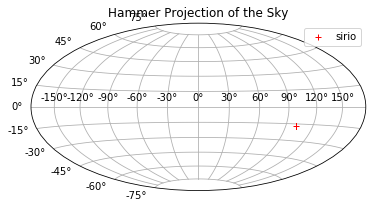

In [13]:
plt.figure()
plt.subplot(111, projection="hammer")
plt.plot( sirio.alpha, sirio.delta,'r+', label='sirio')
plt.title("Hammer Projection of the Sky")
plt.legend()
plt.grid(True)

In [14]:
from scipy.interpolate import interp1d
x = np.linspace(0, 10, num=11, endpoint=True)
y = np.cos(-x**2/9.0)
f = interp1d(x, y, kind='linear')
f2 = interp1d(x, y, kind='cubic')

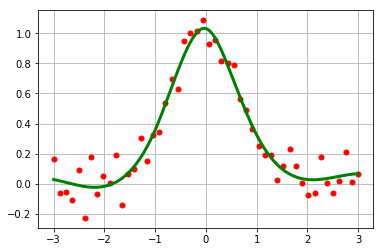

knots: [-3.  -1.  -0.5  0.   0.5  1.   3. ]


In [15]:
from scipy.interpolate import LSQUnivariateSpline, UnivariateSpline
import matplotlib.pyplot as plt
x = np.linspace(-3, 3, 50)
y = np.exp(-x**2) + 0.1 * np.random.randn(50)
t = [-1, -0.5, 0, 0.5, 1]
spl = LSQUnivariateSpline(x, y, t)
xs = np.linspace(-3, 3, 1000)
plt.plot(x, y, 'ro', ms=5)
plt.plot(xs, spl(xs), 'g-', lw=3)
plt.grid()
plt.show()
print('knots: {}'.format(spl.get_knots()))

In [16]:
def deBoor(k, x, t, c, p):
    """
    Evaluates S(x).

    Args
    ----
    k: index of knot interval that contains x
    x: position
    t: array of knot positions, needs to be padded as described above
    c: array of control points
    p: degree of B-spline
    """
    d = [c[j + k - p] for j in range(0, p+1)]
    for r in range(1, p+1):
        for j in range(p, r-1, -1):
            alpha = (x - t[j+k-p]) / (t[j+1+k-r] - t[j+k-p])
            d[j] = (1.0 - alpha) * d[j-1] + alpha * d[j]
    return d[p]

In [17]:
def B(x, k, i, t):
    if k == 0:
        return 1.0 if t[i] <= x < t[i+1] else 0.0
    if t[i+k] == t[i]:
        c1 = 0.0
    else:
        c1 = (x - t[i])/(t[i+k] - t[i]) * B(x, k-1, i, t)
    if t[i+k+1] == t[i+1]:
        c2 = 0.0
    else:
        c2 = (t[i+k+1] - x)/(t[i+k+1] - t[i+1]) * B(x, k-1, i+1, t)
    return c1 + c2

def bspline(x, t, c, k):
    n = len(t) - k - 1
    assert (n >= k+1) and (len(c) >= n)
    return sum(c[i] * B(x, k, i, t) for i in range(n))

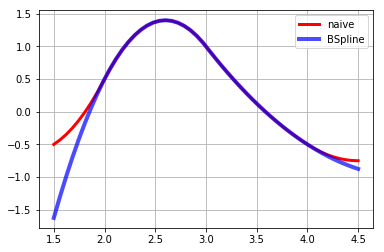

In [18]:
from scipy.interpolate import BSpline
k = 2
t = [0, 1, 2, 3, 4, 5, 6]
c = [-1, 2, 0, -1]
spl = BSpline(t, c, k)
spl(2.5)

bspline(2.5, t, c, k)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
xx = np.linspace(1.5, 4.5, 50)
ax.plot(xx, [bspline(x, t, c ,k) for x in xx], 'r-', lw=3, label='naive')
ax.plot(xx, spl(xx), 'b-', lw=4, alpha=0.7, label='BSpline')
ax.grid(True)
ax.legend(loc='best')
plt.show()

In [19]:
a = np.sort(np.random.rand(3))
a

array([0.1374747 , 0.13927635, 0.90340192])

In [20]:
from scipy.interpolate import InterpolatedUnivariateSpline

k = 4
length = 10
xv = [0, 1, 2, 3, 4, 4.5, 5]
x = np.sort(list(set(xv)))
y = [3, 6, 5, 7, 9, 9, 1]
spline = InterpolatedUnivariateSpline(x, y, k=4)
spline_list = [spline]

In [21]:
from scipy.interpolate import splrep
from scipy.interpolate import splev
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import BSpline

x = [0, 1, 2, 3, 4, 4.5, 5]
y = [3, 6, 5, 7, 9, 9, 1]

k = 4
my_spline = InterpolatedUnivariateSpline(x, y, k)
my_spline

error: failed in converting 1st keyword `w' of dfitpack.fpcurf0 to C/Fortran array

In [22]:
from scipy.interpolate import BSpline
def extend_knots(internal_knots, k):
    extended_knots = []
    for i in range(k):
        extended_knots.append(internal_knots[0])
    extended_knots += list(internal_knots)
    for i in range(k):
        extended_knots.append(internal_knots[-1])
    return extended_knots

def spline_from_coeffs(coeffs, knots, k):
    """
    :param k: B-spline order"""
    # extended_knots = extend_knots(knots, k=order)
    print('LLLLLLLLLLLLLLLLLLLLLLLL', len(knots))
    return BSpline(knots, coeffs, k) 

In [23]:
a = [[0,1], [0,1]]
np.array(a).shape

(2, 2)

In [26]:
my_spline.get_coeffs().shape

(7,)

In [27]:
my_spline.get_knots().shape

(4,)

In [42]:
knots

array([0. , 2.5, 3.5, 5. ])

In [43]:
basis_bsplines.t

array([-1. , -1. ,  0. ,  2.5,  3.5,  5. ,  6. ,  6. ])

In [32]:
print(coeffs.shape,'\n',knots.shape,'\n', np.array(internal_knots).shape)

(7,) 
 (4,) 
 (12,)


extended knots [0.0, 0.0, 0.0, 0.0, 0.0, 2.5, 3.5, 5.0, 5.0, 5.0, 5.0, 5.0]
len xv and coeffs 7 7
splrep knots: [0.  0.  0.  0.  0.  2.5 3.5 5.  5.  5.  5.  5. ]
internal_knots: [0.0, 0.0, 0.0, 0.0, 0.0, 2.5, 3.5, 5.0, 5.0, 5.0, 5.0, 5.0]
old_coeffs: [ 3.         10.43074106  0.61411201  8.9464517   7.33896593 12.77615743
  1.          0.          0.          0.          0.          0.        ]
coeffs: [ 3.         10.43074106  0.61411201  8.9464517   7.33896593 12.77615743
  1.        ]
knots: [0.  2.5 3.5 5. ]
tck mod: ([0.0, 0.0, 0.0, 0.0, 0.0, 2.5, 3.5, 5.0, 5.0, 5.0, 5.0, 5.0], array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False]), 4)
tck mod: ([0.0, 0.0, 0.0, 0.0, 0.0, 2.5, 3.5, 5.0, 5.0, 5.0, 5.0, 5.0], array([False,  True, False, False, False, False, False, False, False,
       False, False, False, False]), 4)
tck mod: ([0.0, 0.0, 0.0, 0.0, 0.0, 2.5, 3.5, 5.0, 5.0, 5.0, 5.0, 5.0], array([False, False,  True, False, False, Fals

/home/zampieri/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


AttributeError: 'BSpline' object has no attribute 'evaluate_all_bspl'

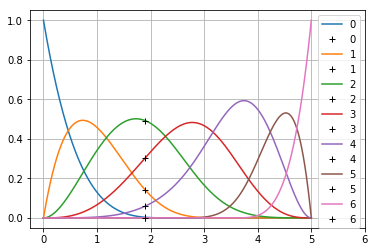

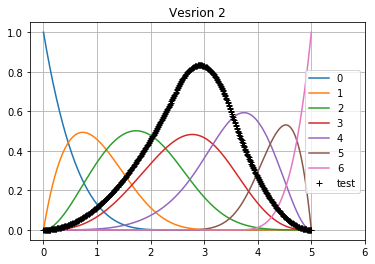

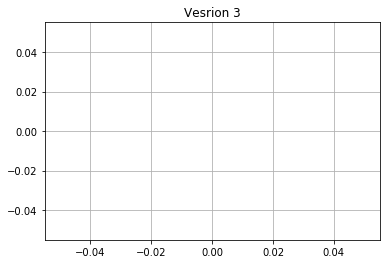

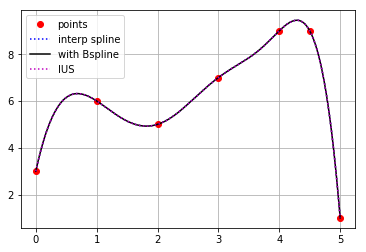

In [46]:
from scipy.interpolate import splrep
from scipy.interpolate import splev
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import BSpline

t  = [ 1, 2, 3, 4]
xv = [0, 1, 2, 3, 4, 4.5, 5]
xv = np.sort(list(set(xv)))
yv = [3, 6, 5, 7, 9, 9, 1]

k = 4
tck = splrep(xv, yv, s=0, k=k)
my_spline = InterpolatedUnivariateSpline(xv, yv, k=k)
coeffs = my_spline.get_coeffs()
knots = my_spline.get_knots()
print('extended knots', extend_knots(knots, k))
internal_knots = []
for i in range(k):
    internal_knots.append(knots[0])
internal_knots += list(knots)
for i in range(k):
    internal_knots.append(knots[-1])

print('len xv and coeffs', len(xv), len(coeffs))
print('splrep knots: {}'.format(tck[0]))
print('internal_knots: {}'.format(internal_knots))
print('old_coeffs: {}'.format(tck[1]))
print('coeffs: {}'.format(coeffs))
print('knots: {}'.format(knots))
xx = np.linspace(min(xv), max(xv), 500)
bsplines = []
f1 = plt.figure()
for j in range(len(xv)):
    new_coeffs = np.arange(len(xv)+2*k-2) == j
    # print('new_coeffs: {}'.format(new_coeffs))
    tck_mod = (list(tck[0]), new_coeffs, k)
    print('tck mod:', tck_mod)
    current_bspline = splev(xx, tck_mod)
    my_x = 1.90
    bsplines.append(current_bspline)
    plt.plot(xx, current_bspline, label=str(j))
    plt.plot(my_x, splev(my_x, tck_mod), 'k+', label=str(j))
plt.grid()
plt.legend()
plt.xticks(np.arange(0, len(xv)))
f1.show()

my_Bspline = BSpline(internal_knots, coeffs, k=k)
basis_bsplines = my_Bspline.basis_element(knots, extrapolate=False)

bsplines2 = []
f3 = plt.figure()
for j, coeff in enumerate(coeffs):
    bool_array = np.arange(len(coeffs)) == j
    tck_mod = (internal_knots, bool_array, k)
    print('tck mod:', tck_mod)
    current_bspline2 = splev(xx, tck_mod)
    #print(current_bspline2[:,0])
    bsplines2.append(current_bspline2)
    plt.plot(xx, current_bspline2, label=str(j))
plt.plot(xx, basis_bsplines(xx) ,'+k', label='test')
plt.grid()
plt.title('Vesrion 2')
plt.legend()
plt.xticks(np.arange(0, len(coeffs)))
f3.show()

f4 = plt.figure()
tck_mod = ([internal_knots[2]], [True], k)
plt.plot(xx, splev(xx, tck_mod), 'k', label = 'test')
plt.title('Vesrion 3')
plt.grid()
f4.show()

# internal_knots = [knots.]
f2 = plt.figure()
print('internal_knots: ', internal_knots)


print('basis_bsplines: ', len(basis_bsplines.t))
print('coeff 0: ', coeffs[0])
#print(bsplines[0], ' || ', coeffs[0])
my_basis = splev(xx, my_Bspline)
print('splev: ',len(my_basis))
interp_spline = sum([coeff*bspline for coeff, bspline in zip(coeffs, bsplines)])
def func(t):
    return sum(coeff*lll for i, coeff in enumerate(coeffs))
#print(interp_spline)
#interp_spline = coeffs*my_basis
plt.plot(xv, yv, 'ro', label='points')
plt.plot(xx, interp_spline, 'b:', label='interp spline' )
plt.plot(xx, my_Bspline(xx, extrapolate=False), 'k-', label='with Bspline')
plt.plot(xx, my_spline(xx), 'm:', label='IUS')
plt.legend()

plt.grid()
f2.show()
print(my_spline(2.5))

my_Bspline.evaluate_all_bspl(knots, k, 1)

In [2]:
lala

NameError: name 'lala' is not defined

In [ ]:
plt.plot(splev(xx, tck))

gaia archive:

In [ ]:
df = pd.read_csv('../data/GaiaSource_1584380076484244352_2200921635402776448.csv',
                 sep=None , delimiter=None, header='infer', engine='python', verbose=True, nrows=100)

In [ ]:
df.head(0)

In [ ]:
# df['source_id'].value_counts()

**Autograd**

In [ ]:
import autograd
from autograd import jacobian
from autograd import grad
import autograd.numpy as np
from autograd.extend import primitive, defvjp
from autograd.test_util import check_grads

def double_sin(x, y):
    out = np.array([np.sin(x), np.cos(y), 1])
    return out  # np.append(out, 2)


# print(double_sin( np.array([1,2]) ))
my_grad = jacobian(double_sin, argnum=0)
print(my_grad(np.pi, np.pi/2))

In [ ]:
@primitive
def my_func(x):
    return np.sin(x)

def my_func_vjp(ans, x):
    x_shape = x.shape
    return lambda g:  np.cos(x) * g # np.full(x_shape, g)

# Now we tell Autograd that logsumexmp has a gradient-making function.
defvjp(my_func, my_func_vjp)

der_my_func = jacobian(my_func)
for my_point in [np.array([np.pi]), np.array([np.pi/4]),  np.array([np.pi/2])]:
    print(der_my_func(my_point), np.cos(my_point))
print(der_my_func(np.array([1, 2, 3])))

In [ ]:
@primitive
def logsumexp(x):
    """Numerically stable log(sum(exp(x))), also defined in scipy.misc"""
    max_x = np.max(x)
    return max_x + np.log(np.sum(np.exp(x - max_x)))

def logsumexp_vjp(ans, x):
    x_shape = x.shape
    return lambda g: np.full(x_shape, g) * np.exp(x - np.full(x_shape, ans))

# Now we tell Autograd that logsumexmp has a gradient-making function.
defvjp(logsumexp, logsumexp_vjp)

def example_func(y):
    z = y**2
    lse = logsumexp(z)
    return np.sum(lse)

grad_of_example = grad(example_func)
my_array = np.linspace(-10, 10, 10)
print('Shape of my array: {}'.format(my_array.shape))
print("Gradient: \n", grad_of_example(my_array))

# Check the gradients numerically, just to be safe.
# check_grads(example_func, modes=['rev'])(my_array)

In [ ]:
plot_longitud_latitude(gaia, t_init, t_end, my_dt)

In [ ]:
import matplotlib.pylab as plt
import numpy as np

class Line:
    def __init__(self, slope, intercept):
        self.slope = slope
        self.intercept = intercept

    def calculate(self, x1):
        x2 = x1 * self.slope + self.intercept
        return x2

A = np.array([[1, 1], [1, 2], [1, 3]])
b = np.array([1, 2, 2])

x0, x1 = np.linalg.solve(A.T.dot(A), A.T.dot(b))
lsq = Line(x1, x0)

# figure
plt.scatter(A[:, 1], b, marker='x', color='black')

points = np.array([0.5, 3.5])
plt.plot(points, lsq.calculate(points))

plt.scatter(A[:, 1], lsq.calculate(A[:, 1]), marker='o', color='red')
plt.vlines(A[:, 1], b, lsq.calculate(A[:, 1]))

plt.show()

x = np.array([[x0], [x1]])
p = A.dot(x).reshape(-1)
e = p - b
print (p.dot(e))

In [ ]:
# This is an example how to make a plot in the Aitoff projection using data
# in a SkyCoord object. Here a randomly generated data set will be used. The
# final script can be found below.

# First we need to import the required packages. We use
# `matplotlib <http://www.matplotlib.org/>`_ here for
# plotting and `numpy <http://www.numpy.org/>`_  to get the value of pi and to
# generate our random data.
from astropy import units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import numpy as np

# We now generate random data for visualisation. For RA this is done in the range
# of 0 and 360 degrees (``ra_random``), for DEC between -90 and +90 degrees
# (``dec_random``). Finally, we multiply these values by degrees to get an
# `~astropy.units.Quantity` with units of degrees.
ra_random = np.random.rand(100)*360.0 * u.degree
dec_random = (np.random.rand(100)*180.0-90.0) * u.degree

# As next step, those coordinates are transformed into an astropy.coordinates
# astropy.coordinates.SkyCoord object.
c = SkyCoord(ra=ra_random, dec=dec_random, frame='icrs')

# Because matplotlib needs the coordinates in radians and between :math:`-\pi`
# and :math:`\pi`, not 0 and :math:`2\pi`, we have to convert them.
# For this purpose the `astropy.coordinates.Angle` object provides a special method,
# which we use here to wrap at 180:
ra_rad = c.ra.wrap_at(180 * u.deg).radian
dec_rad = c.dec.radian

# As last step we set up the plotting environment with matplotlib using the
# Aitoff projection with a specific title, a grid, filled circles as markers with
# a markersize of 2 and an alpha value of 0.3.
plt.figure(figsize=(8,4.2))
plt.subplot(111, projection="aitoff")
plt.title("Aitoff projection of our random data", y=1.08)
plt.grid(True)
plt.plot(ra_rad, dec_rad, 'o', markersize=2, alpha=0.3)
plt.plot(0, 1, 'r+', markersize=10, alpha=1)
plt.subplots_adjust(top=0.95,bottom=0.0)
plt.show()